# DIY Figure 1

In this *Do It Yourself (DIY) Figure 1* notebook, one can use the theoretical approximation developed in Sapienza et al. 2023 to change the parameter choices from those illustrated in Figure 1 of the paper. This notebook thereby enables a researcher to obtain estimates of the angular error for the paleopole estimation for a set of parameters that fits their study such as the latitude and the estimated within site precision. 

<table style="border-collapse: collapse; border: none;">
    <tr>
        <td style="border: none;"><img src="https://github.com/PolarWandering/PaleoSampling/blob/b894fcdc15dc64ab46cd16cf297572dbc280abbd/figures/figure1/Figure1.png?raw=true" width="500"></td>
        <td style="border: none; vertical-align: bottom; width: 300px;">
            <b>Figure 1:</b> Root mean square error (RMSE) in degrees between site mean poles and the true GAD pole (top panel) and between-site VGP dispersion (bottom panel) as a function of different combinations of the total number of sites N and the number of samples per site n0. For this diagram, we use a paleolatitude of 30° (κb ≈ 35), poutlier = 0, and κw = 50. The white dashed lines represent isolines where the total number of samples n is constant, and the black lines represent isolines with constant net mean error angle. Each point-wise estimate of the mean error (i.e., each box) is based on the results of 10,000 simulations. While these simulations represent secular variation using model G, similar results emerge from using the TK03 model (Tauxe & Kent, 2004). <b>This notebook allows you to recreate the top panel using the theoretical approximation</b>
        </td>
    </tr>
</table>

A full simulation would be more computationally expensive to run, but our simulations showed that theoretical approximations and numerical simulations differ at most $1\%$ from each other when there are no outliers in the sample. 

## Import Python packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.ndimage.filters import gaussian_filter
import matplotlib.colors as colors
from itertools import product

import smpsite as smp

%matplotlib inline

/var/folders/yz/k237ph5966sct06x3qf_9dt40000gn/T/ipykernel_62804/2317696597.py:4: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter


## The parameters of the study location

The first step is to provide the latitude and longitude of the study location (the latitude is what matters).

You also need to provide an estimate of $\kappa$ which is the Fisher precision parameter for the sample directions within the individual sites of your study. If the directional estimates within a given site are expected to be tightly grouped, this `kappa_within_site` value will be higher. If they are expected to be more scattered it will be lower.

**Change the values below to match the study for which you are interested in exploring sampling strategies**

In [2]:
site_lat = 30             # Site latitude
site_long = 0             # Site longitude
kappa_within_site = 50    # Concentration parameter kappa in each site


## The number of sites and samples per site to be evaluated

The maximum number of sites (`N_max`) and the maximum number of samples per site (`n0_max`) can be set. In Figure 1 of the paper, `N_max`` was 40 and `n0_max`` was 20. At values of very high site numbers and/or sample numbers there can be an issue with the code, 

In [55]:
N_max = 100 # Maximum values of sites (can go up to ~300)
n0_max = 10  # Maximum values of samples per site

In [56]:
# Create a template data frames with all the combinations of number of sites and samples per site
N_flat = np.tile(np.arange(1, N_max+1, 1), (n0_max,1)).ravel()
n0_flat = np.tile(np.arange(1, n0_max+1, 1), (N_max,1)).T.ravel()

df = pd.DataFrame({'N' : N_flat, 'n0' : n0_flat})

# Compute theoretical error in paleopole estimation

df["error_kappa_theoretical"] = df.apply(lambda row: smp.kappa_theoretical(smp.Params(N=row.N, 
                                                                                      n0=row.n0, 
                                                                                      kappa_within_site=kappa_within_site,
                                                                                      site_lat=site_lat,
                                                                                      site_long=site_long, 
                                                                                      outlier_rate=0.0, 
                                                                                      secular_method='G', 
                                                                                      kappa_secular=None)), axis=1)

df["error_angle_theoretical"] = df.apply(lambda row: float(smp.kappa2angular(row.error_kappa_theoretical)), axis=1)
df.head(5)

,N,n0,error_kappa_theoretical,error_angle_theoretical
0,1,1,18.528499,19.134249
1,2,1,35.056998,13.793211
2,3,1,52.585497,11.204579
3,4,1,70.113995,9.690172
4,5,1,87.642494,8.676167


### Figure

We define a function that will make the heatmap. 

In [57]:
def find_nearest(A, a0):
    """
    Function to round all the values in a generic numpy array A to the closest value in another array n0.
    """
    a = A.flatten()
    idx = ((np.tile(a, (len(a0),1)).T - a0)**2).argmin(axis=1)
    return a0[idx].reshape(A.shape)

def plot_angle_error(df):
    
    fig, axes = plt.subplots()
    fig.set_size_inches(14, 10)
    
    caxes    = axes.inset_axes([1.04, 0.26, 0.03, 0.4])
    
    def contour_plot(df_, ax, cax, bounds, cmap, cbar_title, make_levels=True, make_contours=True, color_max=16, ticks=None, xmax=40):
    
        X = df_.columns.values
        Y = df_.index.values
        Z = df_.values
        Z_smooth = gaussian_filter(Z, 1.0)
    
        Z = np.clip(Z, a_min=0.0, a_max=color_max)
        # Z_rounded = np.rint(Z)
        mid_points = (bounds[1:] + bounds[:-1]) / 2
        Z_rounded = find_nearest(Z, mid_points)
        Z_rounded[np.isnan(Z)] = 0

        x,y = np.meshgrid(X, Y)

        if make_levels:
            N = x * y
            levels = np.hstack([np.arange(0.0, 100.0, 20), np.arange(100.0, 310, 40.)])
            IsoNLines = ax.contour(x, y, N, 10, colors='white', linestyles="dashed", levels=levels)
            ax.clabel(IsoNLines, inline=True, fontsize=10)

        ColorGrid = ax.pcolormesh(x, y, Z_rounded, cmap=cmap, norm=colors.LogNorm(vmin=2, vmax=color_max), alpha=0.8)
        
        if make_contours:
            ContourLines = ax.contour(x, y, Z, 10, colors='k', levels=bounds)  
            ax.clabel(ContourLines, inline=True, fontsize=14)

        ax.set_xlim([1, n0_max])
        ax.set_ylim([0, N_max])
        ax.set_xlabel(None)
        ax.set_ylabel(None)
        # ax.set_xticks([1,2,3,4,5,6,7,10,15])
        ax.xaxis.set_tick_params(labelsize=16)
        ax.yaxis.set_tick_params(labelsize=16)
    
        cbar = plt.colorbar(ColorGrid, cax=cax, boundaries=bounds, orientation='vertical')#, fraction=0.02, location='right')
        cbar.set_label(cbar_title, rotation=270, fontsize=20, labelpad=20)
     
        return None
    
    contour_plot(df, 
                 axes, 
                 cax=caxes,
                 bounds=np.hstack([np.arange(0.0, 5.0, 0.5), np.arange(5.0, 8, 1.0), np.arange(8.0, 16.0, 2.0)]), 
                 cmap='viridis', 
                 cbar_title="RMSE for pole estimation (degrees)",
                 color_max=14, 
                 ticks=[1, 4, 7, 10, 15, 20, 30, 40])

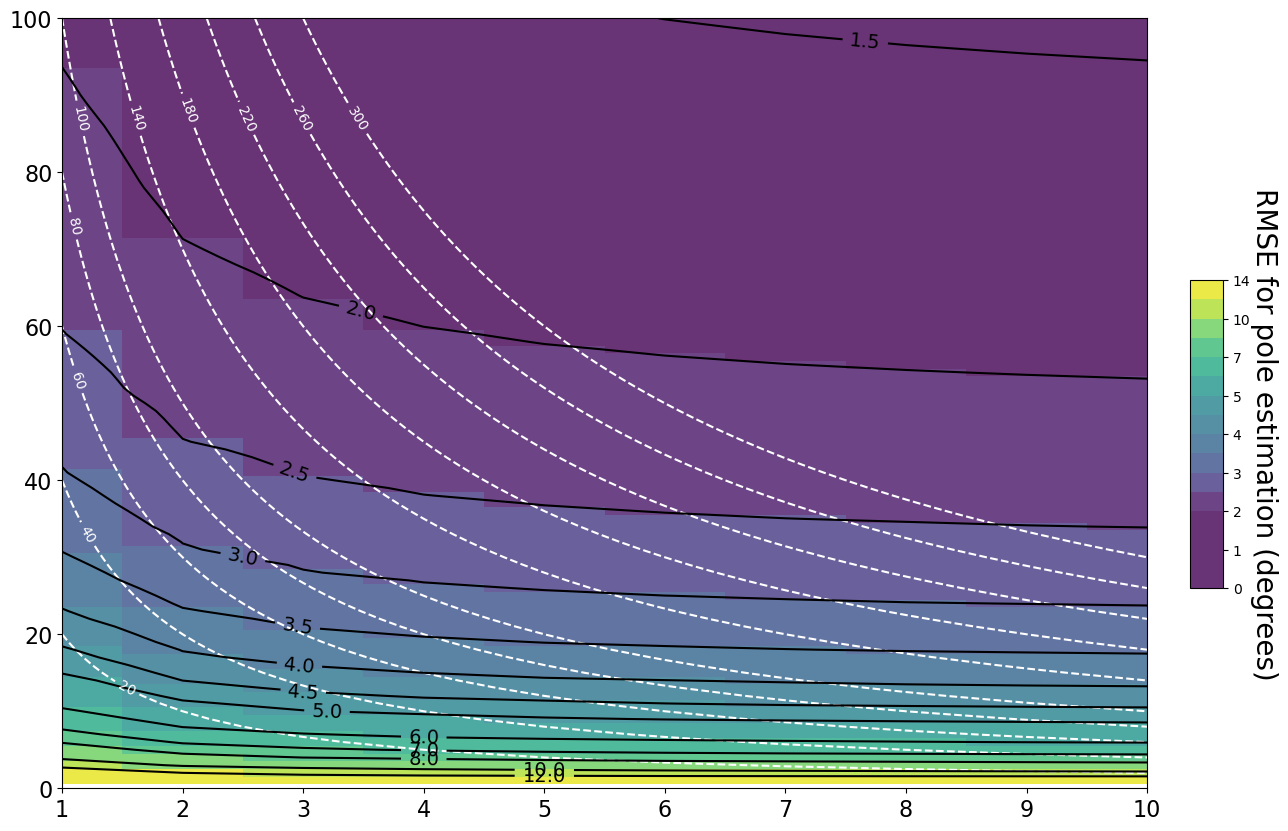

In [58]:
df_pivot = df.pivot(index='N', columns='n0', values='error_angle_theoretical')

plot_angle_error(df_pivot)